# Yandex Data Science School
## Linear Regression & Regularization Exercise.


## Outline
In this exercise you will learn the following topics:

1. Refresher on how linear regression is solved in batch and in Gradient Descent 
2. Implementation of Ridge Regression
3. Comparing Ridge, Lasso and vanila Linear Regression on a dataset

## Refresher on Ordinary Least Square (OLS) aka Linear Regeression

### Lecture Note

In Matrix notation, the matrix $X$ is of dimensions $n \times p$ where each row is an example and each column is a feature dimension. 

Similarily, $y$ is of dimension $n \times 1$ and $w$ is of dimensions $p \times 1$.

The model is $\hat{y}=X\cdot w$ where we assume for simplicity that $X$'s first columns equals to 1 (one padding), to account for the bias term.

Our objective is to optimize the loss $L$ defines as residual sum of squares (RSS): 

$L_{RSS}=\frac{1}{N}\left\Vert Xw-y \right\Vert^2$ (notice that in matrix notation this means summing over all examples, so $L$ is scalar.)

To find the optimal $w$ one needs to derive the loss with respect to $w$.

$\frac{\partial{L_{RSS}}}{\partial{w}}=\frac{2}{N}X^T(Xw-y)$ (to see why, read about [matrix derivatives](http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf) or see class notes )

Thus, the gardient descent solution is $w'=w-\alpha \frac{2}{N}X^T(Xw-y)$.

Solving $\frac{\partial{L_{RSS}}}{\partial{w}}=0$ for $w$ one can also get analytical solution:

$w_{OLS}=(X^TX)^{-1}X^Ty$

The first term, $(X^TX)^{-1}X^T$ is also called the pseudo inverse of $X$.

See [lecture note from Stanford](https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf) for more details.


## Exercise 1 - Ordinary Least Square
* Get the boston housing dataset by using the scikit-learn package. hint: [load_boston](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html)

* What is $p$? what is $n$ in the above notation? hint: [shape](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.shape.html)

* write a model `OrdinaryLinearRegression` which has a propoery $w$ and 3 methods: `fit`, `predict` and `score` (which returns the MSE on a given sample set). Hint: use [numpy.linalg.pinv](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.pinv.html) to be more efficient.

* Fit the model. What is the training MSE?

* Plot a scatter plot where on x-axis plot $Y$ and in the y-axis $\hat{Y}_{OLS}$

* Split the data to 75% train and 25% test 20 times. What is the average MSE now for train and test? Hint: use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) or [ShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html).

* Use a t-test to proove that the MSE for training is significantly smaller than for testing. What is the p-value? Hint: use [scipy.stats.ttest_rel](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_rel.html). 

* Write a new class `OrdinaryLinearRegressionGradientDescent` which inherits from `OrdinaryLinearRegression` and solves the problem using gradinet descent. The class should get as a parameter the learning rate and number of iteration. Plot the class convergance. What is the effect of learning rate? How would you find number of iteration automatically? Note: Gradient Descent does not work well when features are not scaled evenly (why?!). Be sure to normalize your features first.

* The following parameters are optional (not mandatory to use):
    * early_stop - True / False boolean to indicate to stop running when loss stops decaying and False to continue.
    * reset - True / False boolean to reset starting w values, relevant in gradient descent OlsCd and OlsGd. Usually its reseted to 0's
    * verbose- True/False boolean to turn on / off logging, e.g. print details like iteration number and loss (https://en.wikipedia.org/wiki/Verbose_mode)
    * track_loss - True / False boolean when to save loss results to present later in learning curve graphs

##### 1. Getting the dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, ShuffleSplit

In [2]:
# load_boston() # This is deprecated

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_dataset = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_dataset.values[::2, :], raw_dataset.values[1::2, :2]])
target = raw_dataset.values[1::2, 2]

df_data = pd.DataFrame(data)
df_y = pd.DataFrame(target)

In [3]:
df_data

#  Variables in order:
#  CRIM     per capita crime rate by town
#  ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
#  INDUS    proportion of non-retail business acres per town
#  CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
#  NOX      nitric oxides concentration (parts per 10 million)
#  RM       average number of rooms per dwelling
#  AGE      proportion of owner-occupied units built prior to 1940
#  DIS      weighted distances to five Boston employment centres
#  RAD      index of accessibility to radial highways
#  TAX      full-value property-tax rate per $10,000
#  PTRATIO  pupil-teacher ratio by town
#  B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
#  LSTAT    % lower status of the population
#  MEDV     Median value of owner-occupied homes in $1000's

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


##### 2. What is p & n in the above notation

$n$ in the above notation is 506 (506 samples).

$p$ in the above notation is 13 (13 features).

##### 3. Write a model OrdinaryLinearRegression

In [4]:
# * write a model `Ols` which has a propoery $w$ and 3 methods: `fit`, `predict` and `score`.? hint: use [numpy.linalg.pinv](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.pinv.html) to be more efficient.

class Ols(object):
  def __init__(self):
    self.w = None
    self.is_fitted = False
    
  @staticmethod
  def pad(X):
    X = X.copy()
    X['padding'] = np.ones(X.shape[0])
    return X
  
  def fit(self, X, Y):
    X = Ols.pad(X)
    self._fit(X, Y)
    self.is_fitted = True
    
  def _fit(self, X, Y):
    Xt = X.T # X transpose (notated as Xt)
    XtX = Xt @ X # Xt * X
    Xty = Xt @ Y # Xt * Y
    # We will use the closed form solution for normal OLS
    self.w = np.linalg.pinv(XtX) @ Xty

  
  def predict(self, X):
    if not self.is_fitted:
      raise RuntimeError("Cannot predict before fitting!")
    #return wx
    return self._predict(X)
  
  def _predict(self, X):
    X = Ols.pad(X)
    return np.matmul(X, self.w)
    
  def score(self, X, Y):
    #return MSE
    if not self.is_fitted:
      raise RuntimeError("Cannot score before fitting!")
    
    y_preds = self.predict(X).to_numpy()
    y_true = Y.to_numpy()
    return np.mean(np.square(y_true - y_preds))


##### 4. Fit the model, what is the training MSE?

In [5]:
ols = Ols()
ols.fit(df_data, df_y)

In [6]:
train_mse = ols.score(df_data, df_y)
print(f"The training MSE is - {train_mse}")


The training MSE is - 21.894831181729206


/var/folders/hp/1nwbq3_d6233ql5yg61wlxg02r6qjf/T/ipykernel_35825/2876316937.py:35: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  return np.matmul(X, self.w)


##### 5. Plot a scatter plot where on x-axis plot $Y$ and in the y-axis $\hat{Y}_{OLS}$ 

/var/folders/hp/1nwbq3_d6233ql5yg61wlxg02r6qjf/T/ipykernel_35825/2876316937.py:35: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  return np.matmul(X, self.w)


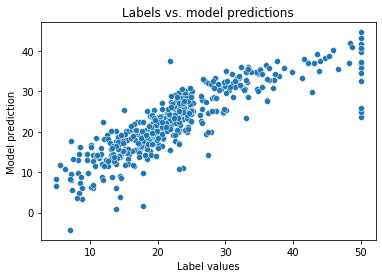

In [7]:
ols_preds = ols.predict(df_data)
sns.scatterplot(x=df_y.values.reshape(-1), 
                y=ols_preds.values.reshape(-1))
plt.title('Labels vs. model predictions')
plt.xlabel('Label values')
plt.ylabel('Model prediction');


##### 6. Split the data to 75% train and 25% test 20 times. What is the average MSE now for train and test?

In [8]:
# Include features + label in the same dataframe prior to split
df_data_labels = df_data.copy()
df_data_labels['y'] = df_y.to_numpy()

# Split 20 times using shuffle split
rs = ShuffleSplit(n_splits=20, test_size=0.25, random_state=42)

i = 1 # Iteration
train_mse_values = []
test_mse_values = []

for train_index, test_index in rs.split(df_data_labels):
    # Get current train features + label
    train_ds = df_data_labels.iloc[train_index]
    x_train = train_ds[[col for col in train_ds.columns.tolist() if col != 'y']]
    y_train = train_ds.y
    # Get current test features + label
    test_ds = df_data_labels.iloc[test_index]
    x_test = test_ds[[col for col in test_ds.columns.tolist() if col != 'y']]
    y_test = test_ds.y
     
    ols = Ols()
    # Fit using current train
    ols.fit(x_train, y_train)
    # Predict on train and test and evaluate the MSE per dataset
    train_mse = ols.score(x_train, y_train)
    test_mse = ols.score(x_test, y_test)
    
    print(f'Split #{i} results - Train MSE[{train_mse}], Test MSE[{test_mse}]')
    train_mse_values.append(train_mse)
    test_mse_values.append(test_mse)
    i+=1

print(f'\nTrain average MSE - {np.mean(train_mse_values)}')
print(f'\nTest average MSE - {np.mean(test_mse_values)}')

Split #1 results - Train MSE[22.34005799215287], Test MSE[22.098694827097344]
Split #2 results - Train MSE[23.644902820078887], Test MSE[17.537101208514176]
Split #3 results - Train MSE[19.293734943653448], Test MSE[32.806136150423725]
Split #4 results - Train MSE[23.502677147749118], Test MSE[18.307919215276847]
Split #5 results - Train MSE[22.58560075021273], Test MSE[20.275976617094443]
Split #6 results - Train MSE[19.94073603220293], Test MSE[28.63216656897583]
Split #7 results - Train MSE[24.275955028826623], Test MSE[16.32458010503079]
Split #8 results - Train MSE[20.33729680765014], Test MSE[28.05274015373092]
Split #9 results - Train MSE[18.3310811663413], Test MSE[35.041822216059145]
Split #10 results - Train MSE[19.97700181765918], Test MSE[29.265989933450815]
Split #11 results - Train MSE[23.31721690527638], Test MSE[18.468274855045216]
Split #12 results - Train MSE[21.359448451480223], Test MSE[24.96668596200835]
Split #13 results - Train MSE[21.846648061601], Test MSE[22.9

##### 7. Use a t-test to proove that the MSE for training is significantly smaller than for testing. What is the p-value?

In [9]:
ttest_res = ttest_rel(train_mse_values, test_mse_values, alternative='less')
ttest_res.pvalue

0.01572396482594443

Therefor, due to the p-value(0.015~), we can say that if we use a 5% significance level for example, we cannot reject the null hypothesis that the train MSE is smaller than the test MSE (which means that it is significance smaller).

##### 8. Write a new class `OrdinaryLinearRegressionGradientDescent` which inherits from `OrdinaryLinearRegression` and solves the problem using gradinet descent


Question: What is the effect of learning rate? 
* The learning will have an impact on the step size we take in the gradient decent towards the minimum. 
* Large learning rate values may cause us to miss the minimum in some cases and even can cause a situation where we will not converge at all.
* Small learning rate values can cause being stuck in a local minimum + takes longer time to train.

Question: How would you find number of iteration automatically? 
* We can use an early stop - Iterating from low to high number of iterations, once we did not see an improvement on the test set in the last X iterations (for example 20 iterations), we stop.

Question: Gradient Descent does not work well when features are not scaled evenly (why?!).
* The reason is that feature with higher range of values may have larger impact on the dirivatives and therefor higher impact on the direction of step we take each time in gradient decent (while we do not necessarily want features with large values to have bigger impact).

In [23]:
class Normalizer():
  # Since I do not know much about the data, we'll using the Z-Score normalization and with the assumption of normal distribution this should be ok.
  def __init__(self):
    self.means = None
    self.stds = None

  def fit(self, X):
    # We are using Z-score for normalization, we will need the means and stds per feature
    self.means = X.mean()
    self.stds = X.std()

  def predict(self, X):

    x_cp = X.copy()
    # Return the normalized value
    return (x_cp - self.means) / self.stds    

class OlsGd(Ols):
  
  def __init__(self, 
               learning_rate=.05, 
               num_iteration=1000, 
               normalize=True,
               early_stop=True,
               verbose=True):
    
    super(OlsGd, self).__init__()
    self.learning_rate = learning_rate
    self.num_iteration = num_iteration
    self.early_stop = early_stop
    self.normalize = normalize
    self.normalizer = Normalizer()    
    self.verbose = verbose
    self.loss_tracking = []

  def _fit(self, X, Y, reset=True, track_loss=True):
    
    X = X.copy()
    # Normalize the data
    if self.normalize:
      self.normalizer.fit(X)
      X = self.normalizer.predict(X)
    
    # Padding
    X = self.pad(X)
    
    # Initialize random weights vector
    self.w = np.random.uniform(low=-1, high=1, size=X.shape[1])

    # Set best loss and counter for itrations without improvement (used for early stop)
    best_loss = self._get_loss(X, Y)
    best_w = self.w
    iters_no_improvement = 0
    

    for iter in range(self.num_iteration):
      
      # Perform the gradient decent step
      self._step(X, Y)

      # Get loss
      loss = self._get_loss(X, Y)
      
      # Update the iterations without improvement counter based on the current iteration loss
      if loss >= best_loss:
        iters_no_improvement += 1
      else:
        iters_no_improvement = 0
        best_loss = loss

      # Check if need to early stop
      if iters_no_improvement > 20 and self.early_stop:
        self.w = best_w
        print(f"Early stopping after {iter} iterations due to early stop!")
        break
      
      # Print iteration log if verbose=True
      if self.verbose:
        print(f'Iteration number {iter} - Loss: {loss}')

      # Add loss to array if track_loss=true
      if track_loss:        
        self.loss_tracking.append(loss)

    print(f'Fitting completed, final loss: {loss}')
        
  def _predict(self, X):

    # Normalize the data if needed
    if self.normalize:
      X = self.normalizer.predict(X)
    
    X = self.pad(X)
    # Predict - Multiply X with the fitted feature weights vector (uses the parent class implementation - Ols._predict)
    return np.matmul(X, self.w)

      
  def _step(self, X, Y):
    
    # Save prev w value
    w_prev = self.w.copy()
    # preds matrix form
    preds = X @ w_prev
    # preds - Y matrix form
    error = preds - Y.iloc[:, 0]
    # Evaluate the gradient
    grad = (X.T @ error) * (1 / Y.shape[0])
    # Update w
    self.w = w_prev - (self.learning_rate * grad)

  def _get_loss(self, X, Y):
    # Return the rss loss based on current weights    
    Xw_minus_y = (X @ self.w) - Y.iloc[:, 0]
    return 0.5 * (Xw_minus_y.T @ Xw_minus_y)



In [24]:
olsgd = OlsGd(learning_rate=0.05, 
              num_iteration=1000, 
              normalize=True,
              early_stop=True,
              verbose=True)
olsgd.fit(X=df_data, Y=df_y)

Iteration number 0 - Loss: 256518.4944090019
Iteration number 1 - Loss: 230473.0788990187
Iteration number 2 - Loss: 208059.10085284436
Iteration number 3 - Loss: 188365.86450834203
Iteration number 4 - Loss: 170858.45997148895
Iteration number 5 - Loss: 155192.64012375765
Iteration number 6 - Loss: 141124.63839147898
Iteration number 7 - Loss: 128466.84400255594
Iteration number 8 - Loss: 117065.66675317391
Iteration number 9 - Loss: 106790.17455595432
Iteration number 10 - Loss: 97525.99305194852
Iteration number 11 - Loss: 89171.804075266
Iteration number 12 - Loss: 81637.15297980684
Iteration number 13 - Loss: 74840.93737646932
Iteration number 14 - Loss: 68710.26975208173
Iteration number 15 - Loss: 63179.56116323934
Iteration number 16 - Loss: 58189.74823971012
Iteration number 17 - Loss: 53687.622319657836
Iteration number 18 - Loss: 49625.23754884217
Iteration number 19 - Loss: 45959.38379301287
Iteration number 20 - Loss: 42651.114860798465
Iteration number 21 - Loss: 39665.32

Fitting completed, final loss: 24321.287815546537
Fitting completed, final loss: 5776.1008619114145
Fitting completed, final loss: 5647.76163503566
Fitting completed, final loss: 5539.650951413076
Fitting completed, final loss: 5539.392844456241
Fitting completed, final loss: 5539.392288978042
Early stopping after 876 iterations due to early stop!
Fitting completed, final loss: 5539.392288977489


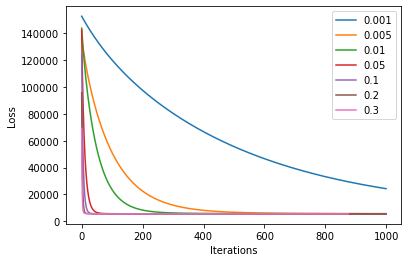

In [22]:
# Plotting the convergence graph
lr_vals = [0.001,0.005,0.01,0.05,0.1,0.2,0.3] 

for a in lr_vals:
    olsgd = OlsGd(learning_rate=a, verbose=False)
    olsgd._fit(df_data, df_y)
    losses = olsgd.loss_tracking
    plt.plot(np.arange(len(losses)),losses)
    
plt.legend(loc="best",labels=lr_vals)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show();

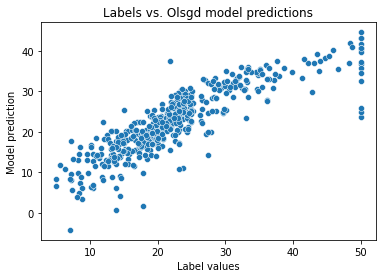

In [13]:
olsgd_preds = olsgd.predict(df_data)

sns.scatterplot(x=df_y.values.reshape(-1), 
                y=olsgd_preds.values.reshape(-1))
plt.title('Labels vs. Olsgd model predictions')
plt.xlabel('Label values')
plt.ylabel('Model prediction');

## Exercise 2 - Ridge Linear Regression

Recall that ridge regression is identical to OLS but with a L2 penalty over the weights:

$L(y,\hat{y})=\sum_{i=1}^{i=N}{(y^{(i)}-\hat{y}^{(i)})^2} + \lambda \left\Vert w \right\Vert_2^2$

where $y^{(i)}$ is the **true** value and $\hat{y}^{(i)}$ is the **predicted** value of the $i_{th}$ example, and $N$ is the number of examples

* Show, by differentiating the above loss, that the analytical solution is $w_{Ridge}=(X^TX+\lambda I)^{-1}X^Ty$
* Change `OrdinaryLinearRegression` and `OrdinaryLinearRegressionGradientDescent` classes to work also for ridge regression (do not use the random noise analogy but use the analytical derivation). Either add a parameter, or use inheritance.
* **Bonus: Noise as a regularizer**: Show that OLS (ordinary least square), if one adds multiplicative noise to the features the **average** solution for $W$ is equivalent to Ridge regression. In other words, if $X'= X*G$ where $G$ is an uncorrelated noise with variance $\sigma$ and mean 1, then solving for $X'$ with OLS is like solving Ridge for $X$. What is the interpretation? 



##### 1. Show, by differentiating the above loss, that the analytical solution is $w_{Ridge}=(X^TX+\lambda I)^{-1}X^Ty$

Starting with:


$$L(y,w)={(y-Xw)^2} + \lambda \left\Vert w \right\Vert_2^2 = {(y-Xw)^T\cdot(y-Xw)} + \lambda w^{T}w = y^{T}y - 2w^{T}X^{T}y
+ w^{T}(X^{T}X +\lambda I)w$$

Taking the dirivative:

$$\frac{\partial{L_{ridge}}}{\partial{w}} = -2X^{T}y +2(X^{T}X+\lambda I)w$$

Dividing by 2 and equating to 0 we get:

$$\frac{\partial{L_{Ridge}}}{\partial{w}}=X^T(Xw-y) + \lambda w=0$$

$$X^TXw-X^Ty + \lambda w=0$$

$$(X^TX + \lambda I)w - X^Ty=0$$

$$(X^TX + \lambda I)w=X^Ty$$

$$w_{Ridge}=(X^TX + \lambda I)^{-1}X^Ty$$

We showed the required analytical solution.


##### 2. Change `OrdinaryLinearRegression` and `OrdinaryLinearRegressionGradientDescent` classes to work also for ridge regression

In [14]:
class RidgeLs(Ols):
  def __init__(self, ridge_lambda, *wargs, **kwargs):
    super(RidgeLs,self).__init__(*wargs, **kwargs)
    self.ridge_lambda = ridge_lambda
    
  def _fit(self, X, Y):
    #Closed form of ridge regression
    Xt = X.T # X transpose (notated as Xt)
    XtX = Xt @ X # Xt * X
    lambda_diag = self.ridge_lambda * np.identity(XtX.shape[0])
    Xty = Xt @ Y # Xt * Y
    # We will use the closed form solution for ridge OLS
    self.w = np.linalg.pinv(XtX + lambda_diag) @ Xty



class RidgeLsGd(OlsGd):
  def __init__(self, ridge_lambda, *wargs, **kwargs):
    super(RidgeLsGd,self).__init__(*wargs, **kwargs)
    self.ridge_lambda = ridge_lambda

  # Override step method
  def _step(self, X, Y):    
    # Save prev w value
    w_prev = self.w.copy()
    # Xw matrix form
    Xw = X @ w_prev
    # Xw - Y matrix form
    Xw_minus_y = Xw - Y.iloc[:, 0]
    # Evaluate the gradient: Xt * (Xw - y) + lambda * w
    grad = (X.T @ Xw_minus_y) + (self.ridge_lambda * w_prev)
    # Update w
    self.w = w_prev - (self.learning_rate * (grad / X.shape[0]))

  # Override loss
  def _get_loss(self, X, Y):
    # Return the loss based on current weights    
    Xw_minus_y = (X @ self.w) - Y.iloc[:, 0]
    rss = 0.5 * np.sum(Xw_minus_y.T @ Xw_minus_y)
    regularization_term = self.ridge_lambda * (self.w.T  @ self.w)
    return rss + regularization_term



In [15]:
ridgels = RidgeLs(ridge_lambda=1)
ridgels.fit(df_data, df_y)

Score - 22.672476936822484


/var/folders/hp/1nwbq3_d6233ql5yg61wlxg02r6qjf/T/ipykernel_35825/2876316937.py:35: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  return np.matmul(X, self.w)


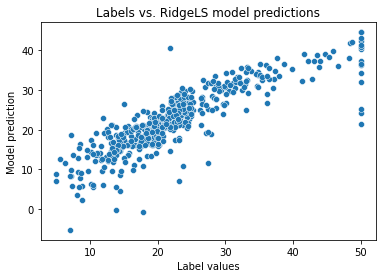

In [16]:
ridgels_preds = ridgels.predict(df_data)
print(f"Score - {ridgels.score(df_data, df_y)}")

sns.scatterplot(x=df_y.values.reshape(-1), 
                y=ridgels_preds.values.reshape(-1))
plt.title('Labels vs. RidgeLS model predictions')
plt.xlabel('Label values')
plt.ylabel('Model prediction');

In [17]:
ridgelsgd = RidgeLsGd(ridge_lambda=1,
              learning_rate=0.05, 
              num_iteration=1000, 
              normalize=True,
              early_stop=True,
              verbose=True)
ridgelsgd.fit(df_data, df_y)

Iteration number 0 - Loss: 130945.75716057107
Iteration number 1 - Loss: 117144.46314304331
Iteration number 2 - Loss: 105515.28272652409
Iteration number 3 - Loss: 95424.13461582079
Iteration number 4 - Loss: 86516.75585292118
Iteration number 5 - Loss: 78578.57206130821
Iteration number 6 - Loss: 71466.68792950176
Iteration number 7 - Loss: 65076.67865635012
Iteration number 8 - Loss: 59326.19466960717
Iteration number 9 - Loss: 54146.70759264374
Iteration number 10 - Loss: 49479.214746507874
Iteration number 11 - Loss: 45271.883105264584
Iteration number 12 - Loss: 41478.65655545416
Iteration number 13 - Loss: 38058.353185967084
Iteration number 14 - Loss: 34974.02194469703
Iteration number 15 - Loss: 32192.44516720579
Iteration number 16 - Loss: 29683.73017971944
Iteration number 17 - Loss: 27420.960712871572
Iteration number 18 - Loss: 25379.89232254561
Iteration number 19 - Loss: 23538.682672791667
Iteration number 20 - Loss: 21877.65089954898
Iteration number 21 - Loss: 20379.06

Score - 146.68013768448844


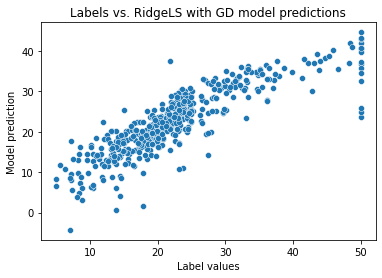

In [18]:

ridgelsgd_preds = ridgelsgd.predict(df_data)
print(f"Score - {ridgelsgd.score(df_data, df_y)}")

sns.scatterplot(x=df_y.values.reshape(-1), 
                y=ridgelsgd_preds.values.reshape(-1))
plt.title('Labels vs. RidgeLS with GD model predictions')
plt.xlabel('Label values')
plt.ylabel('Model prediction');

In [19]:
# Use scikitlearn implementation for OLS, Ridge and Lasso

from sklearn.linear_model import LinearRegression, Ridge, Lasso


clf_lr = LinearRegression()
clf_lr.fit(df_data, df_y)
lr_preds = clf_lr.predict(df_data)


clf_ridge = Ridge(alpha=1.)
clf_ridge.fit(df_data, df_y)
ridge_preds = clf_ridge.predict(df_data)


clf_lasso = Lasso(alpha=0.2)
clf_lasso.fit(df_data, df_y)
lasso_preds = clf_lasso.predict(df_data)

print(f"Linear Regression Score - {clf_lr.score(df_data, df_y)}")
print(f"Ridge Score - {clf_ridge.score(df_data, df_y)}")
print(f"Lasso Score - {clf_lasso.score(df_data, df_y)}")



Linear Regression Score - 0.7406426641094095
Ridge Score - 0.7388703133867616
Lasso Score - 0.7228416777977865


In [20]:
# Prediction examples
print(lr_preds[:5])
print(ridge_preds[:5])
print(lasso_preds[:5])

[[30.00384338]
 [25.02556238]
 [30.56759672]
 [28.60703649]
 [27.94352423]]
[[30.25311604]
 [24.80547336]
 [30.53232402]
 [28.91100981]
 [28.1832052 ]]
[30.8153277  24.92882565 30.61719281 29.51377767 28.57767057]
